# Toy Replica Exchange

This gives a very simple overview of a replica exchange code using `dask`. This is much simpler than a real replica exchange code, but is enough to capture the overall parallelization challenge, which is that swaps can lead to complicated dependency graphs.

Overall, we'll think of several "ensembles" that we are sampling simultaneously. We'll also refer to these as "slots," and they are represented by characters (`'A'`, `'B'`, etc.) The value associated with each slot will be an integer. The goal of this code is to swap which integer is associated with which "ensemble" letter.

In real replica exchange methods, the ensembles are typically temperatures (for REMD) or path ensembles (for RETIS). The values are either points in phase space (for REMD) or trajectories (for RETIS).

In [1]:
import itertools
import random
import time
import dask

In [2]:
class Swapper(object):
    """Perform swap between specific ensembles.
    
    Parameters
    ----------
    elem_1 : character
        first ensemble of swap pair
    elem_2 : character
        second ensemble of swap pair
    """
    def __init__(self, elem_1, elem_2):
        self.elem_1 = elem_1
        self.elem_2 = elem_2
    
    @property
    def pair(self):
        """convenience to return tuple of swap pair"""
        return (self.elem_1, self.elem_2)
    
    def subdict(self, slots):
        """Mapping of ensemble to value for ensembles in this move"""
        return {slot: slots[slot] for slot in self.pair}
        
    def __call__(self, subdict):
        """Perform the swap"""
        time.sleep(1)
        return {self.elem_1: subdict[self.elem_2], self.elem_2: subdict[self.elem_1]}
        
    def __repr__(self):
        return "{}('{}', '{}')".format(self.__class__.__name__, self.elem_1, self.elem_2)

In [3]:
# every character in ensemble_string represents an ensemble
# swappers are created for all pairs
ensemble_string = "ABCDEF"
swappers = [Swapper(*pair) for pair in itertools.combinations(ensemble_string, 2)]

In [4]:
# preselect 20 random swap moves
swaps = [random.choice(swappers) for i in range(20)]

### Run without dask

In [5]:
# initial conditions give the index in the string as the value of that character
slots = {letter: idx for idx, letter in enumerate(ensemble_string)}
slots

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

In [6]:
%%time
for swap in swaps:
    subdict = swap.subdict(slots)
    pairs = swap.pair
    swapped_sub = swap(subdict)
    for slot in pairs:
        slots[slot] = swapped_sub[slot]

CPU times: user 0 ns, sys: 3.42 ms, total: 3.42 ms
Wall time: 20 s


In [7]:
slots

{'A': 5, 'B': 3, 'C': 2, 'D': 4, 'E': 0, 'F': 1}

### Run with dask

In [8]:
# reset initial conditions
slots = {letter: idx for idx, letter in enumerate(ensemble_string)}

Next you'll modify the code to be task-based, using `dask.delayed`. The cell below starts as exactly the same as the example without dask. 

Hints:

1. Does your delayed task return a single object or a tuple? If it returns a tuple of length `N`, use `nout=N`.
2. Is there randomness in your task? If so, use `pure=False`.

In [9]:
# YOUR TURN: modify this code to work with dask.delayed

for swap in swaps:
    subdict = swap.subdict(slots)
    pairs = swap.pair
    #swapped_sub = swap(subdict)
    swapped_sub = dask.delayed(swap, nout=2, pure=False)(subdict)
    for slot in pairs:
        slots[slot] = swapped_sub[slot]

In [10]:
slots

{'A': Delayed('getitem-ae3fb397f2ac6b5f1ed368295945305b'),
 'B': Delayed('getitem-446f432b569ceb83d1c2a2d6eba4b6f7'),
 'C': Delayed('getitem-23cbd42191f7fe4ee2011a778305f122'),
 'D': Delayed('getitem-81201184ad7b1a11d896b5423f1f1dc8'),
 'E': Delayed('getitem-6159600b5cb32b6bd47cd7832c820d6e'),
 'F': Delayed('getitem-0c6f293d249a93114c78646b65f39551')}

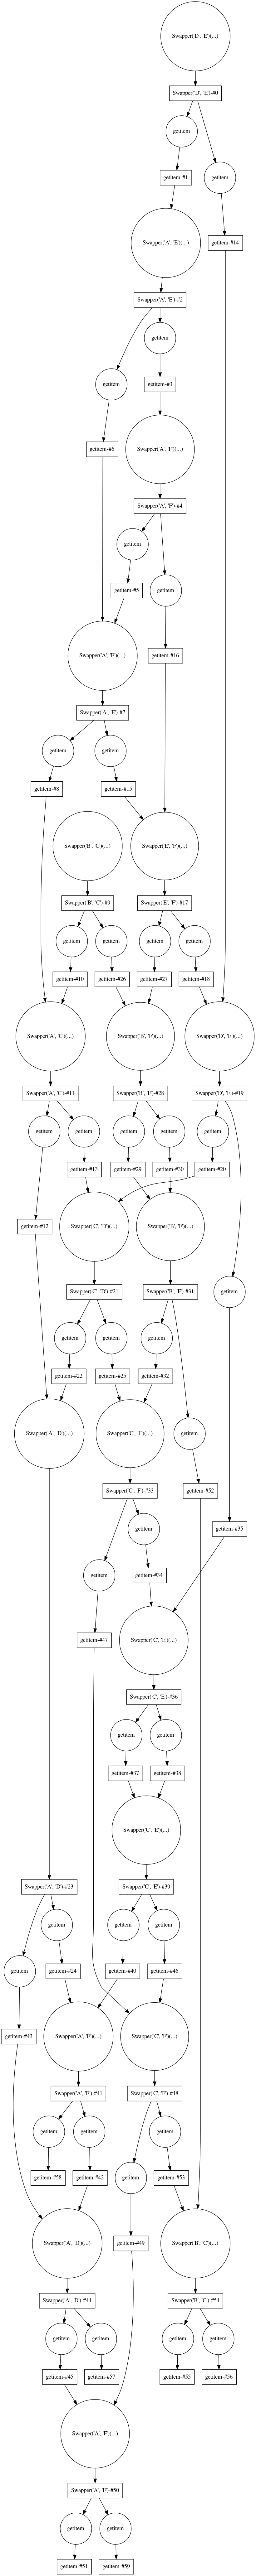

In [12]:
dask.visualize(*slots.values(), rankdir='TB')

In [14]:
# using the distributed scheduler is optional, but its dashboard is nice to watch!
from dask.distributed import Client, LocalCluster

In [5]:
# trick specific in JURECA
host = !hostname
ip = host[0]+'i'
print(ip)

jrl12i


In [6]:
cluster = LocalCluster(ip=ip)
client = Client(cluster)
client

NameError: name 'LocalCluster' is not defined

In [ ]:
%%time
dask.compute(slots)[0]

Because we used the exact same steps, these should give us the same results as the version without dask.

Extra question: What happens if you don't set `pure=False` for your task? Try it. What effect does it have on performance? Do you get the same answer as with `pure=False`?

In [13]:
!hostname

jrc0245
